In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev, BSpline
import sys
sys.path.append('../')
from package_global_functions import *
from filesHandling_quenched import *
from percolationAnalysis import getMeanClusterSize_ir

/home/david/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


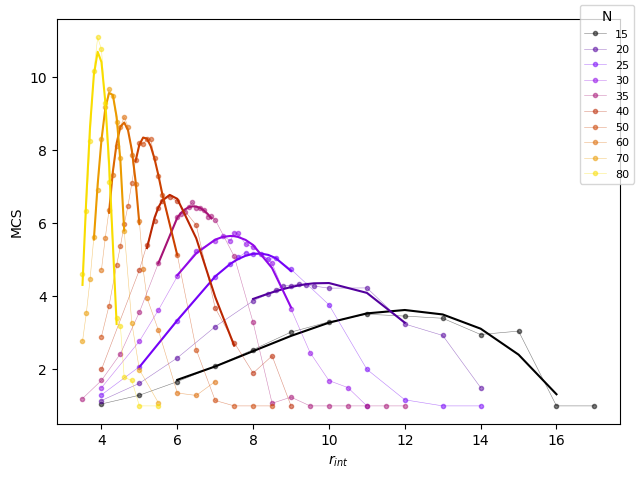

In [8]:
arena_r, exclusion_r, Ns = 20.0, 1.5, [15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
#Ns = [35, ]
push = False
pushLabel = 'nopush'
around_maxs = [5,5,5,5,5,4,4,4,4,4]
ss = [1,2,7,3,3,3,3,3,3,3]

fig, ax = plt.subplots()
colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
percs_from_spline = []
ax.set(xlabel=r'$r_{int}$', ylabel='MCS')
for N,s,around_max,color in zip(Ns, ss, around_maxs, colors):
    irs = availableIrs(N, arena_r, exclusion_r, push)
    dfmcs = getMeanClusterSize_ir(N, arena_r, exclusion_r, irs, push)
    ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
    maxMCS = max(dfmcs['mcs'])
    i = dfmcs[dfmcs.mcs == maxMCS].index[0]
    irs_spline, mcs_spline = np.array(dfmcs.iloc[i-around_max:i+around_max+1].interac_r), np.array(dfmcs.iloc[i-around_max:i+around_max+1].mcs)
    tck_s = splrep(irs_spline, mcs_spline, s=1)
    ax.plot(irs_spline, BSpline(*tck_s)(irs_spline), '-', color=color)
    #Ninterp = len(irs_spline[:-1])*3+1
    #irs_interp = np.linspace(irs_spline[0],irs_spline[-1],Ninterp)
    irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
    mcs_interp = splev(irs_interp,tck_s)
    maxMCS = max(mcs_interp)
    index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
    perc_ir = irs_interp[index_maxMCS]
    percs_from_spline.append(perc_ir)
fig.legend(title='N', fontsize=8)
fig.tight_layout()
fig.savefig(f'MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}_splineMAX.png')

Ns_R20, perc_from_spline_R_20 = Ns.copy(), percs_from_spline.copy()

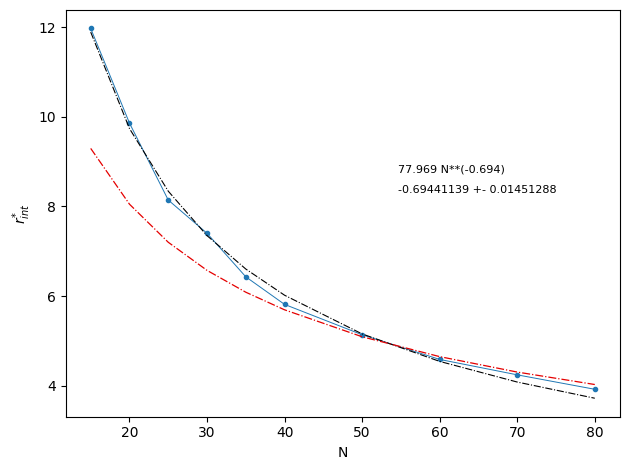

In [9]:
from scipy.optimize import curve_fit

logscale = False

def powerLaw(x,a,b):
    return a*x**b

paramfit, covfit = curve_fit(powerLaw, Ns, percs_from_spline)
fit = powerLaw(Ns, *paramfit)
fig, ax = plt.subplots()
ax.plot(Ns, percs_from_spline, marker='.', lw=0.7)
ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
ax.plot(Ns, 36*np.array(Ns)**(-1/2), ls='-.', color='xkcd:red', lw=0.9)
ax.text(0.6, 0.6, rf'{round(paramfit[0],3)} N**({round(paramfit[1],3)})', fontsize=8, color='k', transform=ax.transAxes)
ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
ax.set(xlabel='N', ylabel=r'$r_{int}^{*}$')
fig.tight_layout()
figname = f'percR_MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
if logscale:
    figname += '_logscale'
figname += '_from_splineMAX.png'
fig.savefig(figname)

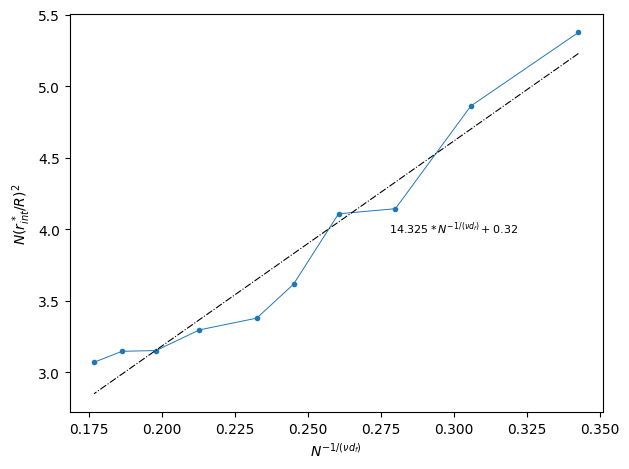

In [10]:
from scipy.optimize import curve_fit

# Finite size scaling
nu, df = 4/3, 182/96

logscale = False

# def powerLaw(x,a,b):
#     return a*x**b

def linFunc(x,a,b):
    return a*x+b

Ns_fsc = np.array(Ns)**(-1/(nu*df))
y_axis = [N*(ri/arena_r)**2 for N,ri in zip(Ns,percs_from_spline)]
Ns_fsc_R20, y_axis_R20 = Ns_fsc.copy(), y_axis.copy()

paramfit, covfit = curve_fit(linFunc, Ns_fsc, y_axis)
fit = linFunc(Ns_fsc, *paramfit)
fig, ax = plt.subplots()
ax.plot(Ns_fsc, y_axis, marker='.', lw=0.7)
ax.plot(Ns_fsc, fit, ls='-.', lw=0.8, color='k')
# ax.plot(Ns, 36*np.array(Ns)**(-1/2), ls='-.', color='xkcd:red', lw=0.9)
ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{-1/(\nu d_f)}} + {round(paramfit[1],3)}$', fontsize=8, color='k', transform=ax.transAxes)
# ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
ax.set(xlabel=r'$N^{-1/(\nu d_f)}$', ylabel=r'$N(r_{int}^* / R)^2$') # , xscale='log', yscale='log'
fig.tight_layout()
figname = f'percR_MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
if logscale:
    figname += '_logscale'
figname += '_from_splineMAX_FSC.png'
fig.savefig(figname)

In [ ]:
from scipy.optimize import curve_fit

# Finite size scaling theoretical parameters
nu, df = 4/3, 182/96
# expected exponents:
exp = -1/(nu*df)
print(f'Expected exponent: {exp}')

logscale = False

def powerLaw(x,a,b,c):
    return a*x**b + c/x

# y_axis = [N*(ri/arena_r)**2 for N,ri in zip(Ns,percs_from_spline)]
y_axis = [(ri/arena_r)**2 for ri in percs_from_spline]
y_axis_R20 = y_axis.copy()

paramfit, covfit = curve_fit(powerLaw, Ns, y_axis, p0 = (20.0, -1.4, 1.0))
fit = powerLaw(Ns, *paramfit)
fig, ax = plt.subplots()
ax.plot(Ns, y_axis, marker='.', lw=0.7)
ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{{round(paramfit[1],3)}}} + {round(paramfit[2],3)}/N$', fontsize=8, color='k', transform=ax.transAxes)
# ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
ax.set(xlabel=r'$N$', ylabel=r'$(r_{int}^* / R)^2$') # , xscale='log', yscale='log'
fig.tight_layout()
# figname = f'percR_MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
# if logscale:
#     figname += '_logscale'
# figname += '_from_splineMAX_FSC.png'
# fig.savefig(figname)

In [ ]:
arena_r, exclusion_r, Ns = 75.0, 1.5, [352, 492, 633, 703, 844, 984]
ss = [1,3,7,3,3,3]
around_maxs = [6,5,5,3,3,3]
push = False
pushLabel = 'nopush'


fig, ax = plt.subplots()
colors = plt.cm.gnuplot(np.linspace(0,0.9,len(Ns)))
percs_from_spline = []
ax.set(xlabel=r'$r_{int}$', ylabel='MCS')
for N,s,around_max,color in zip(Ns, ss, around_maxs, colors):
    irs = availableIrs(N, arena_r, exclusion_r, push)
    dfmcs = getMeanClusterSize_ir(N, arena_r, exclusion_r, irs, push)
    ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
    maxMCS = max(dfmcs['mcs'])
    i = dfmcs[dfmcs.mcs == maxMCS].index[0]
    irs_spline, mcs_spline = np.array(dfmcs.iloc[i-around_max:i+around_max+1].interac_r), np.array(dfmcs.iloc[i-around_max:i+around_max+1].mcs)
    tck_s = splrep(irs_spline, mcs_spline, s=s)
    ax.plot(irs_spline, BSpline(*tck_s)(irs_spline), '-', color=color)
    #Ninterp = len(irs_spline[:-1])*3+1
    #irs_interp = np.linspace(irs_spline[0],irs_spline[-1],Ninterp)
    irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
    mcs_interp = splev(irs_interp,tck_s)
    maxMCS = max(mcs_interp)
    index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
    perc_ir = irs_interp[index_maxMCS]
    percs_from_spline.append(perc_ir)
fig.legend(title='N', fontsize=8)
fig.tight_layout()
fig.savefig(f'MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}_splineMAX.png')

Ns_R75, perc_from_spline_R_75 = Ns.copy(), percs_from_spline.copy()

In [ ]:
from scipy.optimize import curve_fit

# Finite size scaling
nu, df = 4/3, 182/96

logscale = False

# def powerLaw(x,a,b):
#     return a*x**b

def linFunc(x,a,b):
    return a*x+b

print(arena_r)
Ns_fsc = np.array(Ns)**(-1/(nu*df))
y_axis = [N*(ri/arena_r)**2 for N,ri in zip(Ns,percs_from_spline)]
Ns_fsc_R75, y_axis_R75 = Ns_fsc.copy(), y_axis.copy()

paramfit, covfit = curve_fit(linFunc, Ns_fsc, y_axis)
fit = linFunc(Ns_fsc, *paramfit)
fig, ax = plt.subplots()
ax.plot(Ns_fsc, y_axis, marker='.', lw=0.7)
ax.plot(Ns_fsc, fit, ls='-.', lw=0.8, color='k')
# ax.plot(Ns, 36*np.array(Ns)**(-1/2), ls='-.', color='xkcd:red', lw=0.9)
ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{-1/(\nu d_f)}} + {round(paramfit[1],3)}$', fontsize=8, color='k', transform=ax.transAxes)
# ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
ax.set(xlabel=r'$N^{-1/(\nu d_f)}$', ylabel=r'$N(r_{int}^* / R)^2$') # , xscale='log', yscale='log'
fig.tight_layout()
figname = f'percR_MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
if logscale:
    figname += '_logscale'
figname += '_from_splineMAX_FSC.png'
fig.savefig(figname)

In [ ]:
from scipy.optimize import curve_fit

# Finite size scaling theoretical parameters
nu, df = 4/3, 182/96
# expected exponents:
exp = -1/(nu*df)
print(f'Expected exponent: {exp}')

logscale = False

def powerLaw(x,a,b,c):
    return a*x**b + c/x

y_axis = [(ri/arena_r)**2 for _,ri in zip(Ns,percs_from_spline)]

paramfit, covfit = curve_fit(powerLaw, Ns, y_axis, p0 = (20.0, -1.4, 1.0))
fit = powerLaw(Ns, *paramfit)
fig, ax = plt.subplots()
ax.plot(Ns, y_axis, marker='.', lw=0.7)
ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{{round(paramfit[1],3)}}} + {round(paramfit[2],3)}/N$', fontsize=8, color='k', transform=ax.transAxes)
# ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
ax.set(xlabel=r'$N$', ylabel=r'$(r_{int}^* / R)^2$') # , xscale='log', yscale='log'
fig.tight_layout()
# figname = f'percR_MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
# if logscale:
#     figname += '_logscale'
# figname += '_from_splineMAX_FSC.png'
# fig.savefig(figname)

In [ ]:
fig, ax = plt.subplots()
ax.plot(Ns_fsc_R20, y_axis_R20, marker='.', lw=0.7, label='R = 20')
ax.plot(Ns_fsc_R75, y_axis_R75, marker='.', lw=0.7, label='R = 75')
ax.set(xlabel=r'$N^{-1/(\nu d_f)}$', ylabel=r'$N(r_{int}^* / R)^2$')
fig.legend(loc=(0.2,0.75))
fig.tight_layout()
figname = f'percR_MCS_difN_difar_er_{exclusion_r}_{pushLabel}'
figname += '_from_splineMAX_FSC.png'
fig.savefig(figname)

## Keeping the same density

In [ ]:
Ns = [35, 219, 492, 709, 965, 1479]
arena_rs = [20.0, 50.0, 75.0, 90.0, 105.0, 130.0]

exclusion_r = 1.5

ss = [1,5,5,3,3,3]
around_maxs = [6,5,5,3,3,3]
push = False
pushLabel = 'nopush'


fig, ax = plt.subplots()
colors = plt.cm.gnuplot(np.linspace(0,0.9,len(Ns)))
percs_from_spline = []
ax.set(xlabel=r'$r_{int}$', ylabel='MCS')
for N,arena_r,s,around_max,color in zip(Ns, arena_rs, ss, around_maxs, colors):
    irs = availableIrs(N, arena_r, exclusion_r, push)
    dfmcs = getMeanClusterSize_ir(N, arena_r, exclusion_r, irs, push)
    ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
    maxMCS = max(dfmcs['mcs'])
    i = dfmcs[dfmcs.mcs == maxMCS].index[0]
    irs_spline, mcs_spline = np.array(dfmcs.iloc[i-around_max:i+around_max+1].interac_r), np.array(dfmcs.iloc[i-around_max:i+around_max+1].mcs)
    tck_s = splrep(irs_spline, mcs_spline, s=s)
    ax.plot(irs_spline, BSpline(*tck_s)(irs_spline), '-', color=color)
    #Ninterp = len(irs_spline[:-1])*3+1
    #irs_interp = np.linspace(irs_spline[0],irs_spline[-1],Ninterp)
    irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
    mcs_interp = splev(irs_interp,tck_s)
    maxMCS = max(mcs_interp)
    index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
    perc_ir = irs_interp[index_maxMCS]
    percs_from_spline.append(perc_ir)
fig.legend(title='N', fontsize=8)
fig.tight_layout()

In [ ]:
from scipy.optimize import curve_fit

# Finite size scaling theoretical parameters
nu, df = 4/3, 182/96
# expected exponents:
exp = -1/(nu*df)
# print(f'Expected exponent: {exp}')

logscale = False

def powerLaw(x,a,b,c):
    return a*x**b + c

def linFunc(x,a,b):
    return a*x+b

y_axis = [N*(ri/ra)**2 for N,ri,ra in zip(Ns,percs_from_spline,arena_rs)]

Ns_fsc = np.array(Ns)**(-1/(nu*df))
paramfit, covfit = curve_fit(linFunc, Ns_fsc, y_axis)
fit = linFunc(Ns_fsc, *paramfit)
ax.plot(Ns_fsc, fit, ls='-.', lw=0.8, color='k')
print(paramfit)


# paramfit, covfit = curve_fit(powerLaw, Ns, y_axis, p0 = (20.0, -0.3, 1.0))
# fit = powerLaw(Ns, *paramfit)
fig, ax = plt.subplots()
ax.plot(Ns_fsc, y_axis, marker='.', lw=0.7)
ax.plot(Ns_fsc, fit, ls='-.', lw=0.8, color='k')
# ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{{round(paramfit[1],3)}}} + {round(paramfit[2],3)}/N$', fontsize=8, color='k', transform=ax.transAxes)
# ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
ax.set(xlabel=r'$N^{-1/(\nu d_f)}$', ylabel=r'$N(r_{int}^* / R)^2$') # , xscale='log', yscale='log'
fig.tight_layout()
# figname = f'percR_MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
# if logscale:
#     figname += '_logscale'
# figname += '_from_splineMAX_FSC.png'
# fig.savefig(figname)